In [1]:
%matplotlib notebook
import numpy as np
from proj1_helpers import load_csv_data, create_csv_submission
from helpers import *
import matplotlib.pyplot as plt

cheminTrain = 'C:/Users/Raphael/Desktop/EPFL/Machine_Learning/train.csv'
cheminTest =  'C:/Users/Raphael/Desktop/EPFL/Machine_Learning/test.csv'
def compute_mse(y, tx, w):
    return (1/(2*tx.shape[0]))*np.linalg.norm(y-tx@w)**2
def compute_loss_rmse(y,tx,w):
    return (compute_mse(y,tx,w)*2)**0.5
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x
def standardizeNine(x):
    mask = np.any( x == -999, axis=0)
    xWithnine = np.copy(x)
    columnStandardize = (x[:,mask] == -999).astype(int)
    xWithnine[:,mask] = columnStandardize
    return xWithnine
def addColumnNine(x):
    mask = np.any( x == -999, axis=0)
    columnStandardize = (x[:,mask] == -999).astype(int)
    return columnStandardize
    
def standardizeNineByMean(x):
    mask = np.any( x == -999, axis=0)
    print(mask.shape)
    xWithnine = np.copy(x)
    df3 = xWithnine[:,mask]
    for i in range(mask.shape[0]):
        test = df3[:,i]
        test2 = test[test !=-999]
        mean = np.mean(test2)     
        df3[:,i][np.where(test == -999)] = mean
    return df3
    
def build_k_indices(y, k_fold, seed):
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1
    return y_pred

In [2]:
def ridge_regression(y, tx, lambda_):
    txt = tx.transpose()
    lambda_prim = 2*y.shape[0]*lambda_
    identity = np.identity(tx.shape[1])
    w = np.linalg.inv(txt@tx+lambda_prim*identity)@txt@y
    #w= np.linalg.solve(txt@tx+lambda_prim*identity,txt@y)
    loss = compute_mse(y,tx,w)
    return loss,w

In [3]:
def cross_validation_visualization(lambds, mse_tr, mse_te):

    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation (k_fold = 5): Ridge regression")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

# IMPORT DATA

In [4]:
# load data.
yb, input_data, ids = load_csv_data(cheminTrain)
yb_test, input_data_test, ids_test = load_csv_data(cheminTest)


print(input_data)



[[ 138.47    51.655   97.827 ...,    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ..., -999.    -999.      46.226]
 [-999.     162.172  125.953 ..., -999.    -999.      44.251]
 ..., 
 [ 105.457   60.526   75.839 ..., -999.    -999.      41.992]
 [  94.951   19.362   68.812 ..., -999.    -999.       0.   ]
 [-999.      72.756   70.831 ..., -999.    -999.       0.   ]]


# Preprocess

In [23]:
#withoutNine = standardizeNine(input_data)
print(input_data.shape)
print(input_data_test.shape)
#whitoutNine_test = standardizeNine(input_data_test)

angle_column = [15,18,20,25,28]
x_cos = np.copy(input_data)
x_test_cos = np.copy(input_data_test)

for i in angle_column:
    x_cos[:,i] = np.cos(x_cos[:,i])
    x_test_cos[:,i] = np.cos(x_test_cos[:,i])
    
x,_,_ = standardize(x_cos)
x_test,_,_ = standardize(x_test_cos)
x_NineColumn = addColumnNine(input_data)
x_test_NineColumn = addColumnNine(input_data_test)

ones = np.ones((x.shape[0],1))
ones_test = np.ones((x_test.shape[0],1))

x_final = replace_nans_with_median(np.concatenate((x,x_NineColumn,ones),axis=1))
x_final_test = replace_nans_with_median(np.concatenate((x_test,x_test_NineColumn,ones_test),axis=1))

y = (yb + 1) / 2

(250000, 30)
(568238, 30)


In [10]:
def build_poly(x, degree):
    y = np.copy(x)
    for i in range(1,degree):
        y = np.concatenate((y,np.power(x,i+1)),axis=1)
                           
    return y

In [6]:
def split_data(x, y, ratio, seed=1):

    np.random.seed(seed)
    N = len(x)

    n_train = int(ratio * N)
    
    train_index = np.random.choice(N, n_train, replace=False)

    index = np.arange(N)

    mask = np.in1d(index, train_index)

    test_index = np.random.permutation(index[~mask])

    x_train = x[train_index]
    y_train = y[train_index]

    x_test = x[test_index]
    y_test = y[test_index]

    return x_train, y_train, x_test, y_test

def prediction(w_train,tx,y_test):
    
    y_pred1 = predict_labels(w_train,tx)

    for n,i in enumerate(y_test):
        if i==0:
              y_test[n]=-1
            
    right = 0
    wrong = 0

    for i in range(len(y_test)):
        if y_test[i] == y_pred1[i]:
            right +=1 
        else:
            wrong +=1 
    
        
    print("Good prediction : ", right)
    print("Bad predition : " , wrong)
    print("Ratio : " ,right/len(y_test))
    return right/len(y_test)

In [8]:
def replace_nans_with_median(arr, nan=-999):
    '''Creates a copy and replaces the nan values by the median (without thos nan values) in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        copy[:,d][copy[:,d] == nan] = np.median(arr[:,d][arr[:,d] != nan])
        
    return copy
def replace_nans_with_mean(arr, nan=-999):
    '''Creates a copy and replaces the nans values by the mean (without those nan values) in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        copy[:,d][copy[:,d] == nan] = np.mean(arr[:,d][arr[:,d] != nan])
        
    return copy

def replace_nans_with_most_frequent(arr, nan=-999):
    '''Creates a copy and replaces the nan values by the most frequent value in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        unique, counts = np.unique(arr[:,d], return_counts=True)
        copy[:,d][copy[:,d] == nan] = unique[np.argmax(counts[unique != nan])]
        
    return copy

In [22]:
x_NineColumn = addColumnNine(input_data)
x_test_NineColumn = addColumnNine(input_data_test)

lambda_x = 1e-13
lambdas = np.logspace(-14, -9, 30)
degree = 5

x_wout_categ = replace_nans_with_median(np.delete(x,[22],axis = 1))
x_test_wout_categ =  replace_nans_with_median(np.delete(x_test,[22],axis = 1))
x_wout_categ = np.concatenate((np.ones((x_wout_categ.shape[0],1)),x_wout_categ),axis=1)
x_test_wout_categ = np.concatenate((np.ones((x_test_wout_categ.shape[0],1)),x_test_wout_categ),axis=1)


a = build_poly(x_wout_categ,degree)
b = build_poly(x_test_wout_categ,degree)
c = np.concatenate((a,x_NineColumn),axis = 1)
d = np.concatenate((b,x_test_NineColumn),axis = 1)

#c = np.concatenate((np.ones((c.shape[0],1)),c),axis=1)
#d = np.concatenate((np.ones((d.shape[0],1)),d),axis=1)

#loss, w = ridge_regression(y,c,lambda_)
#y_pred = predict_labels(w, d)
print(y_pred.shape)
#create_csv_submission(ids_test, y_pred, 'submission_for_kaggle.csv')

x_train, y_train, x_test, y_test = split_data(c, y, 0.8)
ratios = []

#for ind, lambda_ in enumerate(lambdas):
loss, w = ridge_regression(y_train,x_train,lambda_x)
prediction(w,x_test,y_test)
#ratios.append(prediction(w,x_test,y_test))
    #print("Current lambda = {i}".format(i=lambda_))

#ratio_visualization(lambdas, ratios)




AxisError: axis 1 is out of bounds for array of dimension 1

In [24]:
def ratio_visualization(lambds, ratios):

    plt.clf()
    plt.semilogx(lambds, ratios, marker=".", color='b', label='ratios')
    plt.xlabel("lambda")
    plt.ylabel("ratio")
    plt.title("ratio by lambda")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()
    plt.savefig("ratios by lambda")

In [19]:
print(y_pred.shape)

(568238,)


Good prediction :  37208
Bad predition :  12792
Ratio :  0.74416
Current degrees = 1
Good prediction :  38384
Bad predition :  11616
Ratio :  0.76768
Current degrees = 2
Good prediction :  38837
Bad predition :  11163
Ratio :  0.77674
Current degrees = 3
Good prediction :  39150
Bad predition :  10850
Ratio :  0.783
Current degrees = 4
Good prediction :  39536
Bad predition :  10464
Ratio :  0.79072
Current degrees = 5


<IPython.core.display.Javascript object>


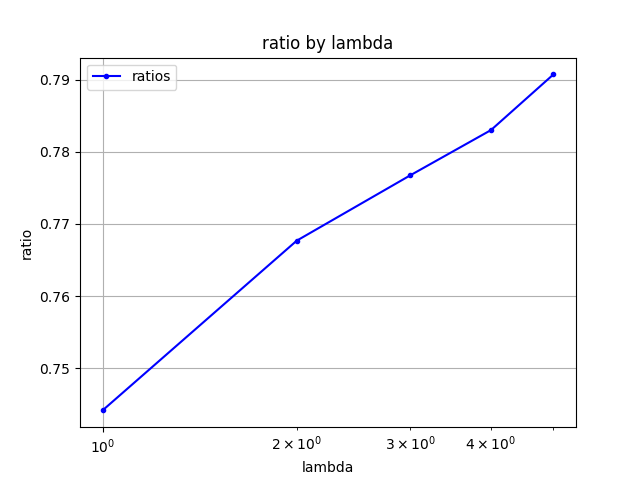

In [22]:
ratios_deg = []
for deg in range(1,6):
    a = build_poly(x_wout_categ,deg)
    b = build_poly(x_test_wout_categ,deg)
    c = np.concatenate((a,x_NineColumn),axis = 1)
    d = np.concatenate((b,x_test_NineColumn),axis = 1)
    x_train, y_train, x_test, y_test = split_data(c, y, 0.8)
    loss, w = ridge_regression(y_train,x_train,lambda_)
    ratios_deg.append(prediction(w,x_test,y_test))
    print("Current degrees = {i}".format(i=deg))

ratio_visualization(range(1,6),ratios_deg)

In [20]:
def degree_visualization(degrees, ratios):

    plt.clf()
    plt.semilogx(degrees, ratios, marker=".", color='b', label='ratios')
    plt.xlabel("degree")
    plt.ylabel("ratio")
    plt.title("ratio by degree")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()
    plt.savefig("ratios by degrees")

# Training removing columns

In [32]:
deg = 4
lam = 1e-9


'''
for column in range(1,30):
    x_final_wout_column = np.delete(x_final,[column],axis = 1)
    x_to_deg = build_poly(x_final_wout_column,deg)
    x_train, y_train, x_test, y_test = split_data(x_to_deg, y, 0.8)
    loss, w = ridge_regression(y_train,x_train,lam)
    print("Current col = {i}".format(i=column))
    prediction(w,x_test,y_test)
'''
#x_final_wout_column = np.delete(x_final,[6,7,15,25,26],axis = 1)
x_to_deg = build_poly(x_final,deg)
x_train, y_train, x_test, y_test = split_data(x_to_deg, y, 0.9)
loss, w = ridge_regression(y_train,x_train,lam)
prediction(w,x_test,y_test)

Good prediction :  19773
Bad predition :  5227
Ratio :  0.79092


0.79092

# Compute corelation on each variable

IndexError: tuple index out of range